In [55]:
import json, os
import pickle
import gensim
import string
import warnings
import re
import json
import numpy as np 
import pandas as pd

from nltk.corpus import stopwords
from nltk import word_tokenize
from pymorphy2 import MorphAnalyzer
from collections import Counter, defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer

morph = MorphAnalyzer()
stops = set(stopwords.words('russian'))

from pymystem3 import Mystem
from collections import defaultdict

warnings.filterwarnings('ignore')
mystem = Mystem()

In [2]:
pd.set_option('display.max_colwidth', 1000)
PATH_TO_DATA = '/Users/macbook/Downloads/data'
files = [os.path.join(PATH_TO_DATA, file) for file in os.listdir(PATH_TO_DATA)]
files.remove('/Users/macbook/Downloads/data/.DS_Store')
data = pd.concat([pd.read_json(file, lines=True) for file in files], axis=0, ignore_index=True)

In [3]:
def evaluate(true_kws, predicted_kws):
    assert len(true_kws) == len(predicted_kws)
    
    precisions = []
    recalls = []
    f1s = []
    jaccards = []
    
    for i in range(len(true_kws)):
        true_kw = set(true_kws[i])
        predicted_kw = set(predicted_kws[i])
        
        tp = len(true_kw & predicted_kw)
        union = len(true_kw | predicted_kw)
        fp = len(predicted_kw - true_kw)
        fn = len(true_kw - predicted_kw)
        
        if (tp+fp) == 0:
            prec = 0
        else:
            prec = tp / (tp + fp)
        
        if (tp+fn) == 0:
            rec = 0
        else:
            rec = tp / (tp + fn)
        if (prec+rec) == 0:
            f1 = 0
        else:
            f1 = (2*(prec*rec))/(prec+rec)
            
        jac = tp / union
        
        precisions.append(prec)
        recalls.append(rec)
        f1s.append(f1)
        jaccards.append(jac)
    print('Precision - ', round(np.mean(precisions), 2))
    print('Recall - ', round(np.mean(recalls), 2))
    print('F1 - ', round(np.mean(f1s), 2))
    print('Jaccard - ', round(np.mean(jaccards), 2))

In [4]:
from string import punctuation
from nltk.corpus import stopwords
punct = punctuation + '«»—…“”*№–'
stops = set(stopwords.words('russian'))

def normalize(text):
    
    words = [word.strip(punct) for word in text.lower().split()]
    words = [morph.parse(word)[0] for word in words if word and word not in stops]
    words = [word.normal_form for word in words if word.tag.POS == 'NOUN']

    return words

Итак, как уже было сказано, наш baseline 0.16 по F1 score. Теперь попробуем хоть как-то что-то улучшить. Это оказалось не так просто.

## 1 Попытка

Давайте соединим title и content, затем используем tfidfvectorizer из sklearn... при этом также изменим norm параметр с l2 на l1

In [5]:
contents = []

for content, title in zip(data['content'], data['title']):
    contents.append('{} {}'.format(title, content))
    
data['content_plus_title'] = contents

In [6]:
%%time

data['content_plus_title_norm'] = data['content_plus_title'].apply(normalize)

CPU times: user 7min 22s, sys: 2.04 s, total: 7min 24s
Wall time: 7min 28s


In [9]:
tfidf = TfidfVectorizer(norm='l1')
tfidf.fit(data['content_plus_title_norm'].apply(' '.join))
id2word = {i:word for i,word in enumerate(tfidf.get_feature_names())}
texts_vectors = tfidf.transform(data['content_plus_title_norm'].apply(' '.join))
keywords = [[id2word[w] for w in top] for top in texts_vectors.toarray().argsort()[:,:-11:-1]]
evaluate(data['keywords'], keywords)

Precision -  0.14
Recall -  0.28
F1 -  0.18
Jaccard -  0.11


Ура, мы сдвинулись с места. Однако, мы видем большую разницу между Precision и Recall...

## 2 Попытка

Поскольку в данный момент, мы берем топ 10 найденных слов, то мы полуаем много дополнительного шума. Давайте посмотрим на зависимость F1 score от количество наших результатов.

In [10]:
def get_f1(true_kws, predicted_kws):
    assert len(true_kws) == len(predicted_kws)
    
    precisions = []
    recalls = []
    f1s = []
    jaccards = []
    
    for i in range(len(true_kws)):
        true_kw = set(true_kws[i])
        predicted_kw = set(predicted_kws[i])
        
        tp = len(true_kw & predicted_kw)
        union = len(true_kw | predicted_kw)
        fp = len(predicted_kw - true_kw)
        fn = len(true_kw - predicted_kw)
        
        if (tp+fp) == 0:
            prec = 0
        else:
            prec = tp / (tp + fp)
        
        if (tp+fn) == 0:
            rec = 0
        else:
            rec = tp / (tp + fn)
        if (prec+rec) == 0:
            f1 = 0
        else:
            f1 = (2*(prec*rec))/(prec+rec)
            
        jac = tp / union
        
        precisions.append(prec)
        recalls.append(rec)
        f1s.append(f1)
        jaccards.append(jac)
    return round(np.mean(f1s), 2)
    

In [11]:
f1_scores = []

for n in range(1, 31):
    f1_scores.append(get_f1(data['keywords'], [[id2word[w] for w in top] for top in texts_vectors.toarray().argsort()[:,:-n:-1]]))

In [12]:
import matplotlib.pyplot as plt

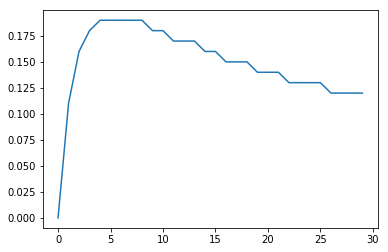

In [13]:
%matplotlib inline

plt.plot(f1_scores)

In [14]:
tfidf = TfidfVectorizer(norm='l1')
tfidf.fit(data['content_plus_title_norm'].apply(' '.join))
id2word = {i:word for i,word in enumerate(tfidf.get_feature_names())}
texts_vectors = tfidf.transform(data['content_plus_title_norm'].apply(' '.join))
keywords = [[id2word[w] for w in top] for top in texts_vectors.toarray().argsort()[:,:-6:-1]]
evaluate(data['keywords'], keywords)

Precision -  0.21
Recall -  0.21
F1 -  0.19
Jaccard -  0.12


Как мы видим, если мы будем брать не топ10, а топ5 слов то результат такжке улучшается

## 3 Попытка

Давайте ради интереса попробуем использовать готовые модули для python. И первым представителем будет rutermextract

In [15]:
%%time

from rutermextract import TermExtractor
term_extractor = TermExtractor()

cheat_keywords = []

for text in data['content_plus_title']:
    cheat_keywords.append([str(term) for term in term_extractor(' '.join(normalize(text)))[:5]])

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/re.py:203: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


CPU times: user 13min 23s, sys: 7.23 s, total: 13min 30s
Wall time: 13min 47s


In [16]:
evaluate(data['keywords'], cheat_keywords)

Precision -  0.17
Recall -  0.17
F1 -  0.16
Jaccard -  0.1


Как видим, улучшения нет.

## 4 Попытка

А если использовать готовый пакет gensim?

In [27]:
%%time

from gensim.summarization import keywords

cheat_keywords = []

for text in data['content_plus_title_norm']:
    cheat_keywords.append([str(term) for term in keywords(' '.join(text)).split('\n')[:5]])

CPU times: user 5min 3s, sys: 10.7 s, total: 5min 14s
Wall time: 5min 14s


In [28]:
evaluate(data['keywords'], cheat_keywords)

Precision -  0.09
Recall -  0.08
F1 -  0.08
Jaccard -  0.05


Совсем провальная попытка.

## 5 Попытка

Давайте попробуем теперь задать новый параметр для нашего TfidfVectorizer и рассмотрим n-граммы.

In [29]:
tfidf = TfidfVectorizer(ngram_range=(1,2), norm='l1')
tfidf.fit(data['content_plus_title_norm'].apply(' '.join))
id2word = {i:word for i,word in enumerate(tfidf.get_feature_names())}
texts_vectors = tfidf.transform(data['content_plus_title_norm'].apply(' '.join))
keywords = [[id2word[w] for w in top] for top in texts_vectors.toarray().argsort()[:,:-6:-1]]
evaluate(data['keywords'], keywords)

Precision -  0.19
Recall -  0.19
F1 -  0.18
Jaccard -  0.11


Все также стоим на месте пока...

## 6 Попытка

Давайте напишем еще одну функцию подготовки текста, которая также будет проводить токенизацию и лемматизацию текста.

In [56]:
def preprocessing(input_text, del_stopwords=True, del_digit=True):
    
    russian_stopwords = set(stopwords.words('russian'))
    words = [x.lower().strip(string.punctuation+'«»—…“”*№–') for x in word_tokenize(input_text)]
    lemmas = [mystem.lemmatize(x)[0] for x in words if x]

    lemmas_arr = []
    for lemma in lemmas:
        if del_stopwords:
            if lemma in russian_stopwords:
                continue
        if del_digit:
            if lemma.isdigit():
                continue
        lemmas_arr.append(lemma)
    return lemmas_arr

In [57]:
data['content_plus_title_prep'] = data['content_plus_title'].apply(preprocessing)

In [58]:
tfidf = TfidfVectorizer(norm='l1')
tfidf.fit(data['content_plus_title_prep'].apply(' '.join))
id2word = {i:word for i,word in enumerate(tfidf.get_feature_names())}
texts_vectors = tfidf.transform(data['content_plus_title_prep'].apply(' '.join))
keywords = [[id2word[w] for w in top] for top in texts_vectors.toarray().argsort()[:,:-6:-1]]
evaluate(data['keywords'], keywords)

Precision -  0.19
Recall -  0.19
F1 -  0.18
Jaccard -  0.11


Я думаю, что это справедливо, ведь если мы посмотрим на ключевые слова, которые у нас уже заданы, то мы можем заметить, что они не лемматизированные. Давайте посмотрем, как измениться наще качество, если мы приведем их к нормальной формой и сравним с нашим результатом.

In [59]:
data['new_keywords'] = [preprocessing(x) for x in [' '.join(x) for x in data['keywords']]]

evaluate(data['new_keywords'], keywords)

Precision -  0.32
Recall -  0.27
F1 -  0.27
Jaccard -  0.17


Теперь мы видим значительное улучшение нашего результата!

Ради теста посмотрим как ведет себя f1 score при разном количестве keywords output

In [62]:
f1_scores = []

for n in range(1, 31):
    f1_scores.append(get_f1(data['new_keywords'], [[id2word[w] for w in top] for top in texts_vectors.toarray().argsort()[:,:-n:-1]]))

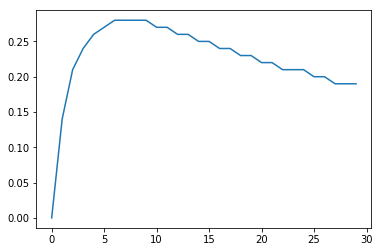

In [63]:
%matplotlib inline

plt.plot(f1_scores)

In [64]:
tfidf = TfidfVectorizer(norm='l1')
tfidf.fit(data['content_plus_title_prep'].apply(' '.join))
id2word = {i:word for i,word in enumerate(tfidf.get_feature_names())}
texts_vectors = tfidf.transform(data['content_plus_title_prep'].apply(' '.join))
keywords = [[id2word[w] for w in top] for top in texts_vectors.toarray().argsort()[:,:-8:-1]]
evaluate(data['new_keywords'], keywords)

Precision -  0.28
Recall -  0.32
F1 -  0.28
Jaccard -  0.18


Итак мы получили наш самый лучший результат 0.28!

## 7 Попытка

Давайте попробуем сделать что-то с нашей старой функцией нормализации. Напрмер... Попробуем использовать дургой модуль для составления списка стоп-слов, в котором будет больше этих самых слов.
Также попробуем использовать LancasterStemmer

In [65]:
from nltk.stem.lancaster import LancasterStemmer
from stop_words import get_stop_words

steammer = LancasterStemmer()

In [68]:
def new_normalize(text):
    
    words = [word.strip(punct) for word in text.lower().split()]
    words = [morph.parse(word)[0] for word in words if word and word not in get_stop_words('russian')]
    words = [word.normal_form for word in words if word.tag.POS == 'NOUN']
    words = [steammer.stem(word) for word in words]

    return words

In [69]:
data['content_plus_title_newnorm'] = data['content_plus_title'].apply(new_normalize)

In [70]:
tfidf = TfidfVectorizer(norm='l1')
tfidf.fit(data['content_plus_title_newnorm'].apply(' '.join))
id2word = {i:word for i,word in enumerate(tfidf.get_feature_names())}
texts_vectors = tfidf.transform(data['content_plus_title_newnorm'].apply(' '.join))
keywords = [[id2word[w] for w in top] for top in texts_vectors.toarray().argsort()[:,:-8:-1]]
evaluate([new_normalize(x) for x in [' '.join(x) for x in data['keywords']]], keywords)

Precision -  0.28
Recall -  0.37
F1 -  0.3
Jaccard -  0.19


Может быть это не очень спортивно, но зато мы добились еще одного улучшения!)